# Logistic Regression Model

In [1]:
# imports
import pandas as pd
from nltk import word_tokenize
from gensim.models import Word2Vec

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import classification_report

/Users/jackoehling/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
FILE = 'processed_concat_data.csv'
concat_df = pd.read_csv(FILE)


data_0 = concat_df[concat_df['cyberbullying_type'] == 0]
data_1 = concat_df[concat_df['cyberbullying_type'] == 1]

sampled_data_0 = data_0.sample(n=56000, random_state=42)
sampled_data_1 = data_1.sample(n=64000, random_state=42)

balanced_df = pd.concat([sampled_data_0, sampled_data_1])

X_dec = balanced_df['processed_tweet_text'].astype(str).tolist()
y_dec = balanced_df['cyberbullying_type'].astype(int).tolist()


sentences = [text.split() for text in X_dec]

# Train a Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5, workers=4)

# Define a function to convert tweets into a single vector by averaging the word vectors
def tweet_vector(tweet, model):
    words = tweet.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

# Apply the function to each tweet in the dataset to create feature vectors
X_w2v = np.array([tweet_vector(text, w2v_model) for text in X_dec])

# Review the shape of the generated feature matrix
X_w2v.shape

(120000, 100)

In [12]:

y = concat_df['cyberbullying_type'].astype(int).tolist()
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_w2v, y_dec, test_size=0.3, random_state=42)

# Initialize the Logistic Regression model
model_w2v = LogisticRegression(random_state=42)  # Increased max_iter for convergence

# Train the model with Word2Vec features
model_w2v.fit(X_train_w2v, y_train)

# Predict on the testing set
y_pred_w2v = model_w2v.predict(X_test_w2v)

# Calculate accuracy and other metrics
accuracy_w2v = accuracy_score(y_test, y_pred_w2v)
classification_rep_w2v = classification_report(y_test, y_pred_w2v)

print(accuracy_w2v)
print(classification_rep_w2v)

0.7394166666666667
              precision    recall  f1-score   support

           0       0.70      0.79      0.74     16905
           1       0.79      0.70      0.74     19095

    accuracy                           0.74     36000
   macro avg       0.74      0.74      0.74     36000
weighted avg       0.75      0.74      0.74     36000



/Users/jackoehling/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [4]:
import numpy as np

def predict_sentiment(new_sentence, model_w2v, logistic_model):
    # Vectorize the new sentence using the pre-trained Word2Vec model
    vectorized_sentence = tweet_vector(new_sentence, model_w2v)
    
    # Predict using the logistic regression model
    prediction = logistic_model.predict([vectorized_sentence])
    prediction_prob = logistic_model.predict_proba([vectorized_sentence])
    
    return prediction[0], prediction_prob[0]

# Example usage
new_sentence = "WTF"
predicted_class, prediction_probability = predict_sentiment(new_sentence, w2v_model, model_w2v)
print("Predicted class:", predicted_class)
print("Prediction probabilities:", prediction_probability)

Predicted class: 0
Prediction probabilities: [0.71340432 0.28659568]


In [5]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Define the model
model = LogisticRegression(random_state=42)

# Define the parameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' works well with l1 and l2 penalty
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train_w2v, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='accuracy')

In [6]:
best_params = grid_search.best_estimator_
best_score = grid_search.best_score_

# printing the optimal hyperparameters and the best accuracy it got
print(best_params, best_score)

LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear') 0.7462142857142857


In [10]:
best_params_pred = best_params.predict(X_test_w2v)
accuracy_best_params = accuracy_score(y_test, best_params_pred)

# accuracy of best model the GridSearchCV found
print(accuracy_best_params)

0.7427222222222222


In [11]:
classification_best_params = classification_report(y_test, best_params_pred)

print(classification_best_params)

              precision    recall  f1-score   support

           0       0.70      0.79      0.74     16905
           1       0.79      0.70      0.74     19095

    accuracy                           0.74     36000
   macro avg       0.75      0.75      0.74     36000
weighted avg       0.75      0.74      0.74     36000



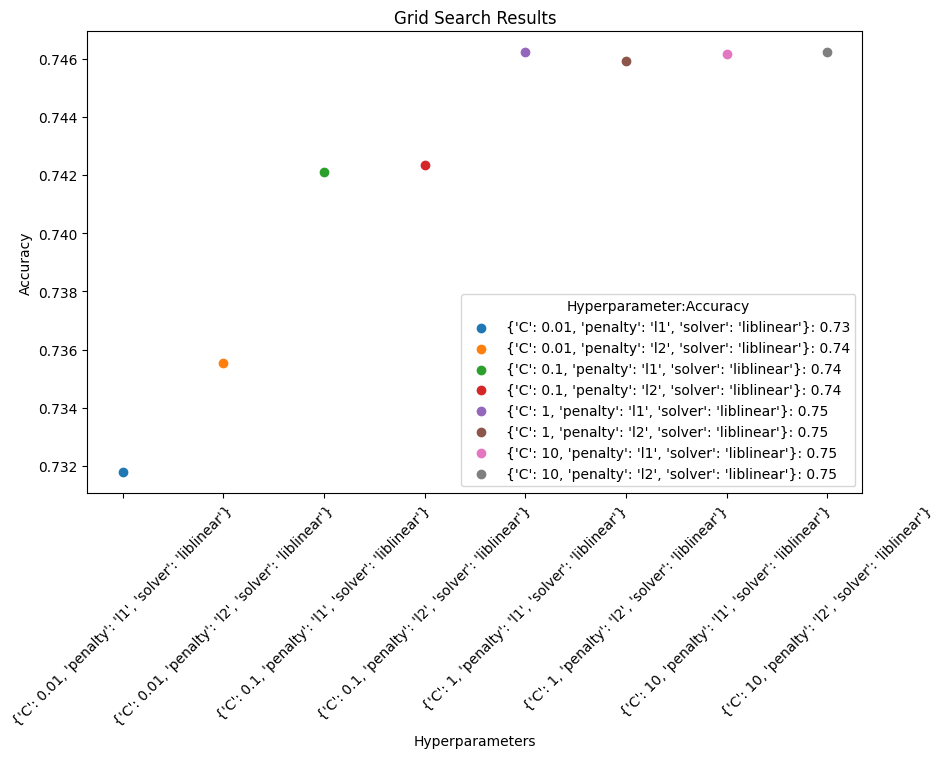

In [8]:

# Extract information for plotting
results = grid_search.cv_results_
mean_scores = results['mean_test_score']
parameters = results['params']

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(len(parameters)):
    ax.scatter(x=str(parameters[i]), y=mean_scores[i], label=f"{parameters[i]}: {mean_scores[i]:.2f}")

ax.set_xlabel('Hyperparameters')
ax.set_ylabel('Accuracy')
ax.set_title('Grid Search Results')
plt.xticks(rotation=45)
ax.legend(title='Hyperparameter:Accuracy', loc='best')
plt.show()

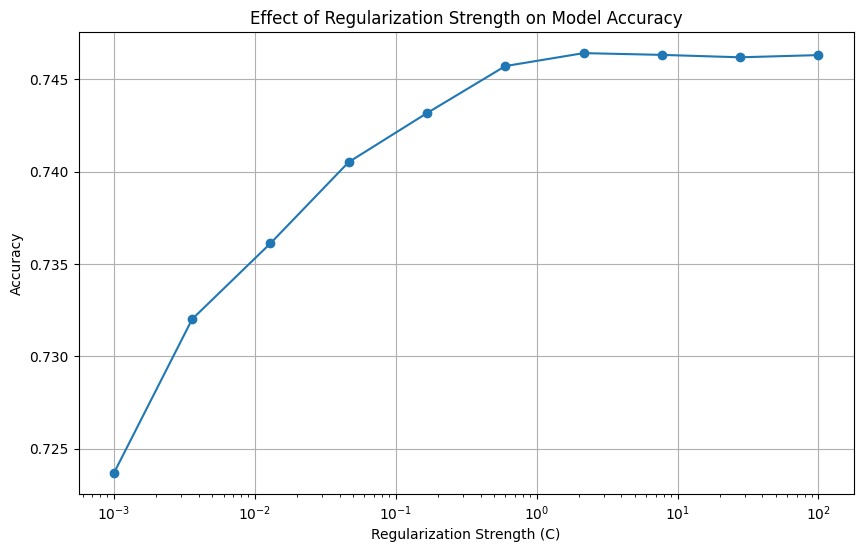

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define the model
model = LogisticRegression(random_state=42, solver='liblinear')  # liblinear is good for small datasets and binary classification

# Define the parameter grid
C_values = np.logspace(-3, 2, 10)  # C values from 0.001 to 100 on a logarithmic scale
param_grid = {'C': C_values}

# Set up GridSearchCV
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy')

# Perform grid search
grid_search.fit(X_train_w2v, y_train)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(C_values, grid_search.cv_results_['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('Regularization Strength (C)')
plt.ylabel('Accuracy')
plt.title('Effect of Regularization Strength on Model Accuracy')
plt.grid(True)
plt.show()